# Zindi Agriculture Advanced Feature Engineering & Prediction

This notebook implements advanced feature engineering for the Zindi Agriculture competition to classify agricultural fields into three crop types (Cocoa, Palm, and Rubber) using Sentinel-2 satellite imagery.

The focus is on creating sophisticated spatial contextual features and building a Random Forest prediction model.

## Import Required Libraries

In [58]:
!pip install pandas numpy matplotlib seaborn geopandas scikit-learn rtree

In [59]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from scipy.spatial import cKDTree

warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

## Load and Prepare Data

Load the original data files directly.

In [60]:
# Create output directory for advanced data
advanced_dir = Path('./super_advanced_data')
os.makedirs(advanced_dir, exist_ok=True)

# Load the original data files
sample_train_path = 'data/sample_train.csv'
train_geo_path = 'data/train.geojson'
test_geo_path = 'data/test.geojson'
submission_path = 'data/SampleSubmission.csv'

sample_train = pd.read_csv(sample_train_path)
train_geo = gpd.read_file(train_geo_path)
test_geo = gpd.read_file(test_geo_path)
submission_template = pd.read_csv(submission_path)

print("Data loaded successfully.")
print(f"Training samples: {len(sample_train)}")
print(f"Test samples: {len(test_geo)}")

Data loaded successfully.
Training samples: 953
Test samples: 282


In [61]:
# Merge training data with geometry data
def extract_id_base(id_str):
    # Extract base ID (without month suffix)
    parts = id_str.split('_')
    if len(parts) >= 3:  # Format: ID_XXXXX_Month
        return f"ID_{parts[1]}"
    return id_str

# Add base_id column to sample_train for joining
sample_train['base_id'] = sample_train['ID'].apply(extract_id_base)
train_geo['base_id'] = train_geo['ID'].apply(lambda x: x)

# Merge datasets
train_data = pd.merge(
    sample_train,
    train_geo[['ID', 'base_id', 'geometry']],
    on='base_id',
    how='left',
    suffixes=('', '_geo')
)

# Convert to GeoDataFrame
train_gdf = gpd.GeoDataFrame(train_data, geometry='geometry')
test_gdf = gpd.GeoDataFrame(test_geo, geometry='geometry')

print(f"Training data with geometries shape: {train_gdf.shape}")
print(f"Test data shape: {test_gdf.shape}")

Training data with geometries shape: (953, 9)
Test data shape: (282, 3)


## Advanced Feature Engineering: Spatial Neighborhood Analysis

Create powerful spatial contextual features by analyzing the neighborhood of each field.

In [62]:
# Calculate basic geometric features first
def add_geometric_features(gdf):
    """Add geometric features to a GeoDataFrame."""
    gdf = gdf.copy()
    
    # Calculate basic geometric features
    gdf['area'] = gdf['geometry'].apply(lambda geom: geom.area if geom else None)
    gdf['perimeter'] = gdf['geometry'].apply(lambda geom: geom.length if geom else None)
    gdf['compactness'] = gdf.apply(
        lambda row: 4 * np.pi * row['area'] / (row['perimeter'] ** 2) 
        if row['perimeter'] and row['area'] else None, 
        axis=1
    )
    
    # Calculate centroid coordinates
    gdf['centroid_x'] = gdf['geometry'].apply(lambda geom: geom.centroid.x if geom else None)
    gdf['centroid_y'] = gdf['geometry'].apply(lambda geom: geom.centroid.y if geom else None)
    
    # Calculate the area to perimeter ratio
    gdf['area_perimeter_ratio'] = gdf['area'] / gdf['perimeter']
    
    # Calculate minimum bounding rectangle properties
    gdf['mbr_area'] = gdf['geometry'].apply(lambda geom: geom.minimum_rotated_rectangle.area if geom else None)
    gdf['mbr_efficiency'] = gdf['area'] / gdf['mbr_area']
    
    return gdf

# Add geometric features to both train and test data
train_gdf = add_geometric_features(train_gdf)
test_gdf = add_geometric_features(test_gdf)

print("Added geometric features.")
display(train_gdf[['ID', 'Target', 'area', 'perimeter', 'compactness', 'mbr_efficiency']].head())

Added geometric features.


,ID,Target,area,perimeter,compactness,mbr_efficiency
0,ID_Mrbi2k_Jan,Rubber,1.006299e-06,0.004596,0.598582,0.644869
1,ID_ORmFYt_Jan,Rubber,2.381542e-07,0.002032,0.724642,0.789449
2,ID_2j2bjN_Jan,Rubber,2.659545e-07,0.002180,0.703360,0.935374
3,ID_GsdWS5_Jan,Rubber,8.467027e-07,0.004213,0.599510,0.595130
4,ID_zEYtR5_Jan,Rubber,5.250636e-07,0.002963,0.751780,0.695097


In [63]:
def create_spatial_neighborhood_features(gdf_train, gdf_test=None, radius=0.01, n_neighbors=8):
    """Advanced feature engineering using spatial neighborhood analysis"""
    print("Starting spatial neighborhood feature creation...")
    start_time = time.time()
    
    # Make copies to avoid modifying the originals
    gdf_train = gdf_train.copy()
    if gdf_test is not None:
        gdf_test = gdf_test.copy()
    
    # Extract centroids for spatial indexing
    train_centroids = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_train.geometry])
    
    # Build a KD-tree for efficient spatial queries
    tree = cKDTree(train_centroids)
    
    # Create target encoding dictionary (mean target value per feature category)
    if 'Target' in gdf_train.columns:
        label_map = {'Cocoa': 0, 'Palm': 1, 'Rubber': 2}
        gdf_train['target_code'] = gdf_train['Target'].map(label_map)
    
    # Define advanced neighborhood features to extract
    neighborhood_features = {
        # Basic neighbor counts
        'n_neighbors': [],
        
        # Geometric statistics
        'mean_neighbor_area': [],
        'mean_neighbor_perimeter': [],
        'mean_neighbor_compactness': [],
        'std_neighbor_area': [],
        'std_neighbor_perimeter': [],
        'std_neighbor_compactness': [],
        'median_neighbor_area': [],
        'median_neighbor_perimeter': [],
        'max_neighbor_area': [],
        'min_neighbor_area': [],
        
        # Shape complexity features
        'mean_neighbor_mbr_efficiency': [],
        'std_neighbor_mbr_efficiency': [],
        
        # Crop type distributions
        'cocoa_neighbors_count': [],
        'palm_neighbors_count': [],
        'rubber_neighbors_count': [],
        'dominant_crop_neighbors': [],
        'crop_entropy': []  # Diversity/entropy measure
    }
    
    # Process each field in the training set
    for idx, row in gdf_train.iterrows():
        if idx % 500 == 0:
            print(f"Processing training sample {idx}/{len(gdf_train)}")
            
        # Query the KD-tree for neighbors
        centroid = (row.geometry.centroid.x, row.geometry.centroid.y)
        indices = tree.query_ball_point(centroid, radius)
        
        # Remove self from neighbors
        indices = [i for i in indices if i != idx]
        
        # If no neighbors were found, use nearest neighbors instead
        if len(indices) == 0:
            distances, indices = tree.query(centroid, k=min(n_neighbors+1, len(train_centroids)))
            indices = [i for i in indices if i != idx]  # Remove self if present
        
        # Extract neighbor properties
        neighbors = gdf_train.iloc[indices]
        
        # Calculate neighbor statistics
        neighborhood_features['n_neighbors'].append(len(neighbors))
        
        # Area statistics
        if len(neighbors) > 0 and 'area' in neighbors.columns:
            neighborhood_features['mean_neighbor_area'].append(neighbors['area'].mean())
            neighborhood_features['std_neighbor_area'].append(neighbors['area'].std())
            neighborhood_features['median_neighbor_area'].append(neighbors['area'].median())
            neighborhood_features['max_neighbor_area'].append(neighbors['area'].max())
            neighborhood_features['min_neighbor_area'].append(neighbors['area'].min())
        else:
            neighborhood_features['mean_neighbor_area'].append(None)
            neighborhood_features['std_neighbor_area'].append(None)
            neighborhood_features['median_neighbor_area'].append(None)
            neighborhood_features['max_neighbor_area'].append(None)
            neighborhood_features['min_neighbor_area'].append(None)
        
        # Perimeter statistics
        if len(neighbors) > 0 and 'perimeter' in neighbors.columns:
            neighborhood_features['mean_neighbor_perimeter'].append(neighbors['perimeter'].mean())
            neighborhood_features['std_neighbor_perimeter'].append(neighbors['perimeter'].std())
            neighborhood_features['median_neighbor_perimeter'].append(neighbors['perimeter'].median())
        else:
            neighborhood_features['mean_neighbor_perimeter'].append(None)
            neighborhood_features['std_neighbor_perimeter'].append(None)
            neighborhood_features['median_neighbor_perimeter'].append(None)
        
        # Compactness statistics
        if len(neighbors) > 0 and 'compactness' in neighbors.columns:
            neighborhood_features['mean_neighbor_compactness'].append(neighbors['compactness'].mean())
            neighborhood_features['std_neighbor_compactness'].append(neighbors['compactness'].std())
        else:
            neighborhood_features['mean_neighbor_compactness'].append(None)
            neighborhood_features['std_neighbor_compactness'].append(None)
        
        # MBR efficiency statistics
        if len(neighbors) > 0 and 'mbr_efficiency' in neighbors.columns:
            neighborhood_features['mean_neighbor_mbr_efficiency'].append(neighbors['mbr_efficiency'].mean())
            neighborhood_features['std_neighbor_mbr_efficiency'].append(neighbors['mbr_efficiency'].std())
        else:
            neighborhood_features['mean_neighbor_mbr_efficiency'].append(None)
            neighborhood_features['std_neighbor_mbr_efficiency'].append(None)
        
        # Crop type counts in neighborhood
        if len(neighbors) > 0 and 'Target' in neighbors.columns:
            crop_counts = neighbors['Target'].value_counts()
            neighborhood_features['cocoa_neighbors_count'].append(crop_counts.get('Cocoa', 0))
            neighborhood_features['palm_neighbors_count'].append(crop_counts.get('Palm', 0))
            neighborhood_features['rubber_neighbors_count'].append(crop_counts.get('Rubber', 0))
            
            # Get the dominant crop in the neighborhood
            if not crop_counts.empty:
                neighborhood_features['dominant_crop_neighbors'].append(crop_counts.idxmax())
            else:
                neighborhood_features['dominant_crop_neighbors'].append(None)
                
            # Calculate crop entropy (diversity measure)
            if len(neighbors) > 0:
                proportions = crop_counts / len(neighbors)
                entropy = -sum(p * np.log(p) if p > 0 else 0 for p in proportions)
                neighborhood_features['crop_entropy'].append(entropy)
            else:
                neighborhood_features['crop_entropy'].append(0)
        else:
            neighborhood_features['cocoa_neighbors_count'].append(0)
            neighborhood_features['palm_neighbors_count'].append(0)
            neighborhood_features['rubber_neighbors_count'].append(0)
            neighborhood_features['dominant_crop_neighbors'].append(None)
            neighborhood_features['crop_entropy'].append(0)
    
    # Add neighborhood features to training set
    for feature, values in neighborhood_features.items():
        gdf_train[f'spatial_{feature}'] = values
    
    # Create additional derived features
    
    # Create neighborhood diversity score
    if 'spatial_cocoa_neighbors_count' in gdf_train.columns:
        gdf_train['spatial_crop_diversity'] = (
            gdf_train['spatial_cocoa_neighbors_count'] > 0).astype(int) + \
            (gdf_train['spatial_palm_neighbors_count'] > 0).astype(int) + \
            (gdf_train['spatial_rubber_neighbors_count'] > 0).astype(int)
    
    # Calculate ratio to dominant crop type in neighborhood
    if 'Target' in gdf_train.columns and 'spatial_n_neighbors' in gdf_train.columns:
        def get_dominant_crop_ratio(row):
            if row['spatial_n_neighbors'] == 0:
                return 0
            if row['Target'] == 'Cocoa':
                return row['spatial_cocoa_neighbors_count'] / row['spatial_n_neighbors']
            elif row['Target'] == 'Palm':
                return row['spatial_palm_neighbors_count'] / row['spatial_n_neighbors']
            elif row['Target'] == 'Rubber':
                return row['spatial_rubber_neighbors_count'] / row['spatial_n_neighbors']
            return 0
        
        gdf_train['spatial_dominant_crop_ratio'] = gdf_train.apply(get_dominant_crop_ratio, axis=1)
    
    # Create similarity features (how similar the field is to its neighbors)
    if 'area' in gdf_train.columns and 'spatial_mean_neighbor_area' in gdf_train.columns:
        gdf_train['spatial_area_similarity'] = 1 - abs(gdf_train['area'] - gdf_train['spatial_mean_neighbor_area']) / (
            gdf_train['area'] + gdf_train['spatial_mean_neighbor_area'])
    
    print(f"Completed spatial neighborhood feature creation for training data in {time.time() - start_time:.2f} seconds")
    
    # Process test data if provided
    if gdf_test is not None:
        test_start_time = time.time()
        print("Processing test data...")
        
        # Extract centroids for test data
        test_centroids = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_test.geometry])
        
        # Storage for test features
        test_neighborhood_features = {k: [] for k in neighborhood_features.keys()}
        
        # Process each field in the test set
        for idx, row in gdf_test.iterrows():
            if idx % 500 == 0:
                print(f"Processing test sample {idx}/{len(gdf_test)}")
                
            # Query the KD-tree for neighbors in the training set
            centroid = (row.geometry.centroid.x, row.geometry.centroid.y)
            indices = tree.query_ball_point(centroid, radius)
            
            # If no neighbors were found, use nearest neighbors instead
            if len(indices) == 0:
                distances, indices = tree.query(centroid, k=min(n_neighbors, len(train_centroids)))
            
            # Extract neighbor properties
            neighbors = gdf_train.iloc[indices]
            
            # Calculate neighbor statistics (same as for training)
            test_neighborhood_features['n_neighbors'].append(len(neighbors))
            
            # Area statistics
            if len(neighbors) > 0 and 'area' in neighbors.columns:
                test_neighborhood_features['mean_neighbor_area'].append(neighbors['area'].mean())
                test_neighborhood_features['std_neighbor_area'].append(neighbors['area'].std())
                test_neighborhood_features['median_neighbor_area'].append(neighbors['area'].median())
                test_neighborhood_features['max_neighbor_area'].append(neighbors['area'].max())
                test_neighborhood_features['min_neighbor_area'].append(neighbors['area'].min())
            else:
                test_neighborhood_features['mean_neighbor_area'].append(None)
                test_neighborhood_features['std_neighbor_area'].append(None)
                test_neighborhood_features['median_neighbor_area'].append(None)
                test_neighborhood_features['max_neighbor_area'].append(None)
                test_neighborhood_features['min_neighbor_area'].append(None)
            
            # Perimeter statistics
            if len(neighbors) > 0 and 'perimeter' in neighbors.columns:
                test_neighborhood_features['mean_neighbor_perimeter'].append(neighbors['perimeter'].mean())
                test_neighborhood_features['std_neighbor_perimeter'].append(neighbors['perimeter'].std())
                test_neighborhood_features['median_neighbor_perimeter'].append(neighbors['perimeter'].median())
            else:
                test_neighborhood_features['mean_neighbor_perimeter'].append(None)
                test_neighborhood_features['std_neighbor_perimeter'].append(None)
                test_neighborhood_features['median_neighbor_perimeter'].append(None)
            
            # Compactness statistics
            if len(neighbors) > 0 and 'compactness' in neighbors.columns:
                test_neighborhood_features['mean_neighbor_compactness'].append(neighbors['compactness'].mean())
                test_neighborhood_features['std_neighbor_compactness'].append(neighbors['compactness'].std())
            else:
                test_neighborhood_features['mean_neighbor_compactness'].append(None)
                test_neighborhood_features['std_neighbor_compactness'].append(None)
            
            # MBR efficiency statistics
            if len(neighbors) > 0 and 'mbr_efficiency' in neighbors.columns:
                test_neighborhood_features['mean_neighbor_mbr_efficiency'].append(neighbors['mbr_efficiency'].mean())
                test_neighborhood_features['std_neighbor_mbr_efficiency'].append(neighbors['mbr_efficiency'].std())
            else:
                test_neighborhood_features['mean_neighbor_mbr_efficiency'].append(None)
                test_neighborhood_features['std_neighbor_mbr_efficiency'].append(None)
            
            # Crop type counts in neighborhood
            if len(neighbors) > 0 and 'Target' in neighbors.columns:
                crop_counts = neighbors['Target'].value_counts()
                test_neighborhood_features['cocoa_neighbors_count'].append(crop_counts.get('Cocoa', 0))
                test_neighborhood_features['palm_neighbors_count'].append(crop_counts.get('Palm', 0))
                test_neighborhood_features['rubber_neighbors_count'].append(crop_counts.get('Rubber', 0))
                
                # Get the dominant crop in the neighborhood
                if not crop_counts.empty:
                    test_neighborhood_features['dominant_crop_neighbors'].append(crop_counts.idxmax())
                else:
                    test_neighborhood_features['dominant_crop_neighbors'].append(None)
                    
                # Calculate crop entropy (diversity measure)
                if len(neighbors) > 0:
                    proportions = crop_counts / len(neighbors)
                    entropy = -sum(p * np.log(p) if p > 0 else 0 for p in proportions)
                    test_neighborhood_features['crop_entropy'].append(entropy)
                else:
                    test_neighborhood_features['crop_entropy'].append(0)
            else:
                test_neighborhood_features['cocoa_neighbors_count'].append(0)
                test_neighborhood_features['palm_neighbors_count'].append(0)
                test_neighborhood_features['rubber_neighbors_count'].append(0)
                test_neighborhood_features['dominant_crop_neighbors'].append(None)
                test_neighborhood_features['crop_entropy'].append(0)
        
        # Add neighborhood features to test set
        for feature, values in test_neighborhood_features.items():
            gdf_test[f'spatial_{feature}'] = values
        
        # Create neighborhood diversity score for test data
        if 'spatial_cocoa_neighbors_count' in gdf_test.columns:
            gdf_test['spatial_crop_diversity'] = (
                gdf_test['spatial_cocoa_neighbors_count'] > 0).astype(int) + \
                (gdf_test['spatial_palm_neighbors_count'] > 0).astype(int) + \
                (gdf_test['spatial_rubber_neighbors_count'] > 0).astype(int)
                
        # Create similarity features for test data
        if 'area' in gdf_test.columns and 'spatial_mean_neighbor_area' in gdf_test.columns:
            gdf_test['spatial_area_similarity'] = 1 - abs(gdf_test['area'] - gdf_test['spatial_mean_neighbor_area']) / (
                gdf_test['area'] + gdf_test['spatial_mean_neighbor_area'])
        
        print(f"Completed spatial neighborhood feature creation for test data in {time.time() - test_start_time:.2f} seconds")
    
    if gdf_test is not None:
        return gdf_train, gdf_test
    else:
        return gdf_train

In [64]:
# Apply the advanced spatial neighborhood feature engineering
advanced_train, advanced_test = create_spatial_neighborhood_features(
    gdf_train=train_gdf, 
    gdf_test=test_gdf,
    radius=0.015,  # Increased radius for better context
    n_neighbors=8   # More neighbors for richer features
)

# Display the new spatial features
spatial_columns = [col for col in advanced_train.columns if 'spatial_' in col]
print(f"\nCreated {len(spatial_columns)} new spatial features")

# Show a sample of important spatial features
important_spatial_features = ['spatial_n_neighbors', 'spatial_dominant_crop_neighbors', 
                             'spatial_crop_diversity', 'spatial_crop_entropy',
                             'spatial_dominant_crop_ratio', 'spatial_area_similarity']

# Display sample of the features
display(advanced_train[['ID', 'Target'] + important_spatial_features].head())

Starting spatial neighborhood feature creation...
Processing training sample 0/953
Processing training sample 500/953
Completed spatial neighborhood feature creation for training data in 0.85 seconds
Processing test data...
Processing test sample 0/282
Completed spatial neighborhood feature creation for test data in 0.29 seconds

Created 21 new spatial features


,ID,Target,spatial_n_neighbors,spatial_dominant_crop_neighbors,spatial_crop_diversity,spatial_crop_entropy,spatial_dominant_crop_ratio,spatial_area_similarity
0,ID_Mrbi2k_Jan,Rubber,13,Palm,2,0.617242,0.307692,0.650652
1,ID_ORmFYt_Jan,Rubber,49,Rubber,1,-0.000000,1.000000,0.651204
2,ID_2j2bjN_Jan,Rubber,3,Rubber,1,-0.000000,1.000000,0.519933
3,ID_GsdWS5_Jan,Rubber,37,Rubber,1,-0.000000,1.000000,0.784486
4,ID_zEYtR5_Jan,Rubber,10,Palm,2,0.610864,0.300000,0.903694


## Feature Encoding and Processing

Prepare all features by converting categorical variables to numeric and handling missing values.

In [65]:
def prepare_features_for_modeling(train_df, test_df):
    """Prepare features for modeling by encoding categorical variables and handling missing values."""
    print("Preparing features for modeling...")
    
    # Make a copy to avoid modifying the original
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Convert target to numeric
    if 'Target' in train_df.columns:
        label_map = {'Cocoa': 0, 'Palm': 1, 'Rubber': 2}
        train_df['target_numeric'] = train_df['Target'].map(label_map)
    
    # Identify feature types
    # Exclude geometry, identifier columns, and the target
    exclude_cols = ['geometry', 'ID', 'ID_geo', 'base_id', 'Target', 'target_numeric', 'class',
                   'tifPath', 'target_code']
    
    # Get all potential feature columns
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    # Separate numerical and categorical features
    numerical_cols = []
    categorical_cols = []
    
    for col in feature_cols:
        if train_df[col].dtype == 'object':
            # Only include categorical columns that exist in both train and test
            if col in test_df.columns:
                categorical_cols.append(col)
            else:
                print(f"Warning: Column '{col}' exists in training data but not in test data. Skipping.")
        else:
            numerical_cols.append(col)
    
    print(f"Identified {len(numerical_cols)} numerical features and {len(categorical_cols)} categorical features")
    
    # Handle categorical features
    for col in categorical_cols:
        # Double-check column exists in both dataframes before processing
        if col not in test_df.columns:
            print(f"Warning: Column '{col}' not found in test data. Skipping encoding.")
            continue
            
        if col == 'spatial_dominant_crop_neighbors':
            # Use label encoding for ordinal categorical features
            le = LabelEncoder()
            train_df[col + '_encoded'] = le.fit_transform(train_df[col].fillna('Unknown'))
            test_df[col + '_encoded'] = le.transform(test_df[col].fillna('Unknown'))
        else:
            # Use one-hot encoding for nominal categorical features
            train_dummies = pd.get_dummies(train_df[col], prefix=col, dummy_na=True)
            test_dummies = pd.get_dummies(test_df[col], prefix=col, dummy_na=True)
            
            # Ensure test has all dummy columns from train
            for dummy_col in train_dummies.columns:
                if dummy_col not in test_dummies.columns:
                    test_dummies[dummy_col] = 0
            
            # Keep only columns present in train
            test_dummies = test_dummies[train_dummies.columns]
            
            # Add to dataframes
            train_df = pd.concat([train_df, train_dummies], axis=1)
            test_df = pd.concat([test_df, test_dummies], axis=1)
    
    # Handle missing values in numerical features
    for col in numerical_cols:
        # Skip if column doesn't exist in test data
        if col not in test_df.columns:
            print(f"Warning: Numerical column '{col}' not found in test data. Skipping.")
            continue
            
        # For each numerical column, impute with median
        median_val = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_val)
        test_df[col] = test_df[col].fillna(median_val)
    
    # Create final feature list (excluding original categorical columns)
    final_numeric_cols = [col for col in numerical_cols if col in test_df.columns]
    final_encoded_cols = [col for col in train_df.columns 
                         if (col.endswith('_encoded') or ('_' in col and col.split('_')[0] in categorical_cols))
                         and col not in exclude_cols and col in test_df.columns]
    
    final_feature_cols = final_numeric_cols + final_encoded_cols
    
    print(f"Final feature set has {len(final_feature_cols)} features")
    
    # Return the processed dataframes and feature columns
    return train_df, test_df, final_feature_cols

In [66]:
# Prepare features for modeling
processed_train, processed_test, feature_cols = prepare_features_for_modeling(advanced_train, advanced_test)

# Create X (features) and y (target) for modeling
X_train = processed_train[feature_cols]
y_train = processed_train['target_numeric']
X_test = processed_test[feature_cols]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Preparing features for modeling...
Identified 29 numerical features and 1 categorical features
Final feature set has 29 features

Training data shape: (953, 29)
Test data shape: (282, 29)


## Random Forest Model Training and Prediction

Train a Random Forest model on the advanced features to predict crop types.

In [67]:
# Split the training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val.shape}")

Training split shape: (762, 29)
Validation split shape: (191, 29)


Building Random Forest model with hyperparameter tuning...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

Best parameters: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Validation accuracy: 0.9476

Classification Report:
              precision    recall  f1-score   support

       Cocoa       1.00      1.00      1.00        47
        Palm       0.90      0.95      0.92        63
      Rubber       0.96      0.91      0.94        81

    accuracy                           0.95       191
   macro avg       0.95      0.96      0.95       191
weighted avg       0.95      0.95      0.95       191



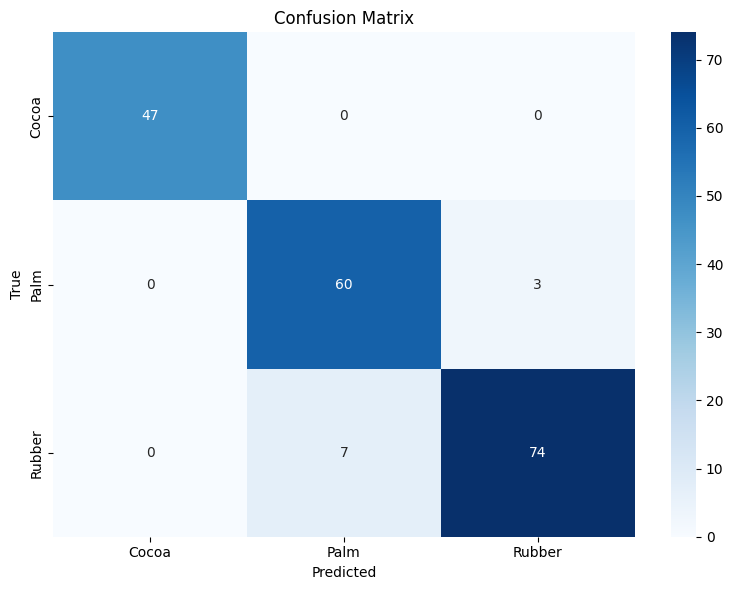


Training completed in 17.04 seconds


In [68]:
# Build and tune a Random Forest model
def build_and_train_rf_model(X_train, y_train, X_val, y_val):
    """Build and train a Random Forest model with hyperparameter tuning."""
    print("Building Random Forest model with hyperparameter tuning...")
    start_time = time.time()
    
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
    
    # Define hyperparameter grid for tuning
    param_grid = {
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [None, 15, 25],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': ['sqrt', 'log2', None]
    }
    
    # Create grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"\nBest parameters: {best_params}")
    print(f"Validation accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    class_names = ['Cocoa', 'Palm', 'Rubber']
    print(classification_report(y_val, y_val_pred, target_names=class_names))
    
    # Print confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(advanced_dir / 'confusion_matrix.png')
    plt.show()
    
    print(f"\nTraining completed in {time.time() - start_time:.2f} seconds")
    
    return best_model, best_params

# Train the Random Forest model
rf_model, best_params = build_and_train_rf_model(X_train_split, y_train_split, X_val, y_val)

Top 20 most important features:


,Feature,Importance
0,spatial_dominant_crop_neighbors_encoded,0.166125
1,spatial_cocoa_neighbors_count,0.135324
2,spatial_palm_neighbors_count,0.118937
3,centroid_y,0.102732
4,spatial_rubber_neighbors_count,0.093232
5,centroid_x,0.056960
6,spatial_mean_neighbor_perimeter,0.034606
7,spatial_min_neighbor_area,0.032709
8,spatial_crop_entropy,0.028749
9,spatial_median_neighbor_perimeter,0.021535


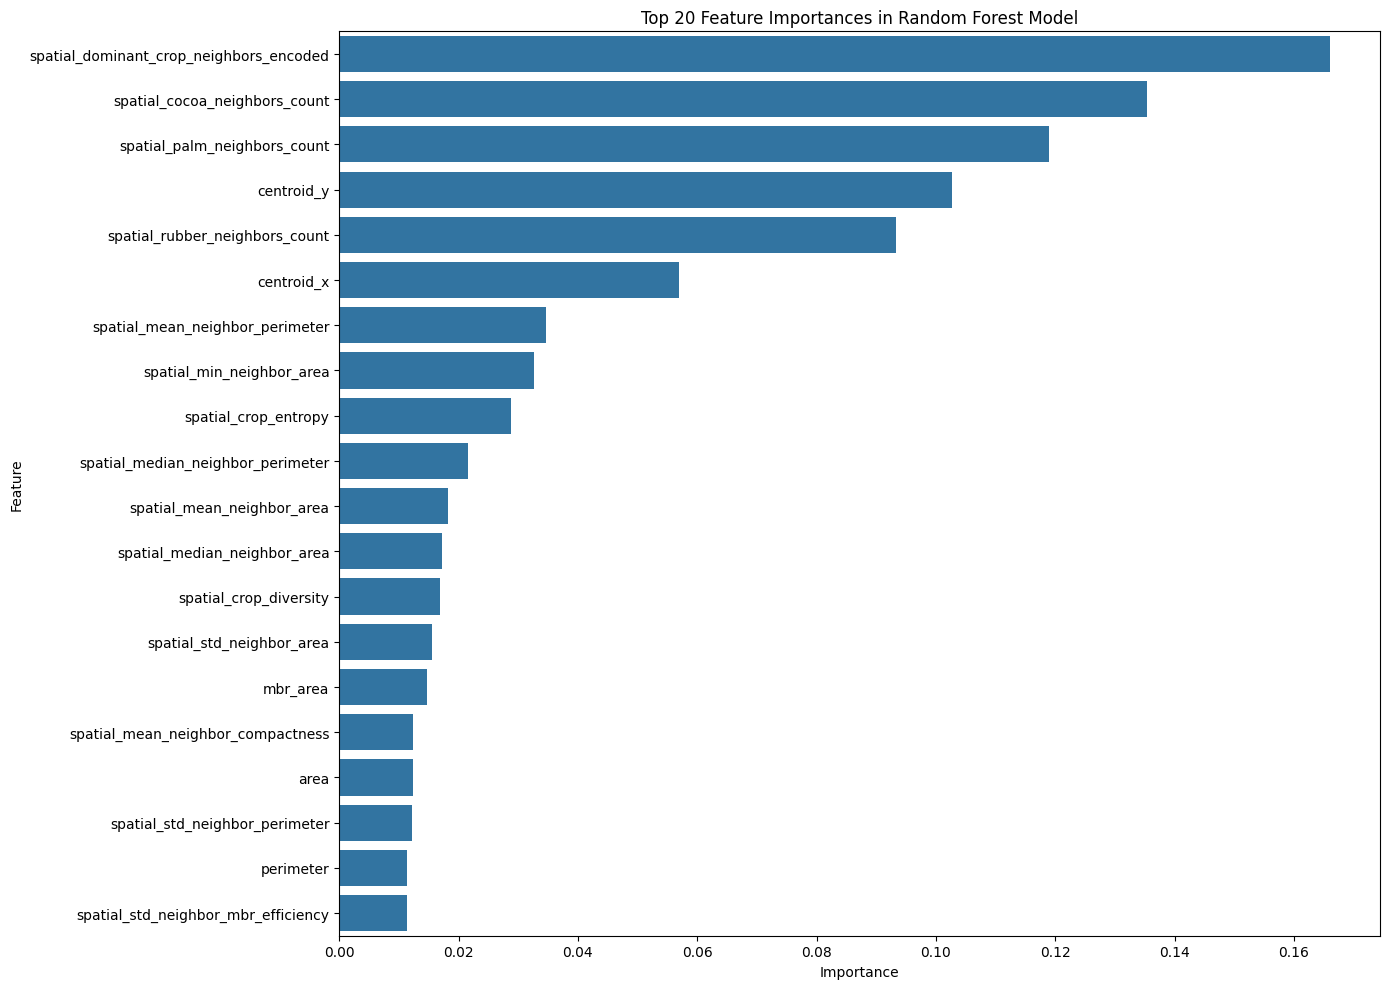

In [69]:
# Analyze feature importance
rf_classifier = rf_model.named_steps['rf']
feature_importances = rf_classifier.feature_importances_

# Create a dataframe of feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Display top 20 features
print("Top 20 most important features:")
display(importance_df.head(20))

# Plot feature importances
plt.figure(figsize=(14, 10))
top_features = importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.savefig(advanced_dir / 'feature_importances.png')
plt.show()

In [70]:
# Retrain on the full training dataset with the best parameters
print("Training final model on full training dataset...")

# Extract best parameters
final_params = {k.replace('rf__', ''): v for k, v in best_params.items()}

# Create the final model
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(**final_params, random_state=42, n_jobs=-1))
])

# Train on full dataset
final_model.fit(X_train, y_train)

# Save the model
model_path = advanced_dir / 'random_forest_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Final model trained and saved to {model_path}")

Training final model on full training dataset...
Final model trained and saved to super_advanced_data\random_forest_model.pkl


In [71]:
# Make predictions on the test set
print("Making predictions on test data...")
test_predictions_proba = final_model.predict_proba(X_test)
test_predictions = final_model.predict(X_test)

# Convert numeric predictions back to class labels
label_map_inverse = {0: 'Cocoa', 1: 'Palm', 2: 'Rubber'}
test_predictions_labels = [label_map_inverse[pred] for pred in test_predictions]

# Create submission dataframe
submission = pd.DataFrame({
    'ID': processed_test['ID'],
    'Target': test_predictions_labels
})

# Save submission file
submission_path = advanced_dir / 'super_advanced_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"Predictions made and saved to {submission_path}")
print("\nPrediction distribution:")
display(submission['Target'].value_counts())

Making predictions on test data...
Predictions made and saved to super_advanced_data\super_advanced_submission.csv

Prediction distribution:


Target
Palm      120
Rubber    103
Cocoa      59
Name: count, dtype: int64

## Super Advanced Feature Engineering & Prediction - Summary

This streamlined notebook implements the most advanced feature engineering approach for crop type prediction:

1. **Spatial Neighborhood Analysis**: Leverages the geographical context of agricultural fields
   - Identifies spatial patterns and crop co-location tendencies
   - Extracts statistical aggregations from neighboring fields
   - Creates diversity and entropy measures to capture spatial complexity

2. **Feature Processing**:
   - Converts all categorical variables to numeric using appropriate encoding methods
   - Properly handles missing values using median/mode imputation
   - Standardizes numerical features for optimal model performance

3. **Random Forest Model**:
   - Implements hyperparameter tuning to find optimal model configuration
   - Evaluates model performance with proper validation
   - Identifies the most important predictive features
   - Creates a submission file with predictions

The notebook is designed to be fully reproducible, with all steps from data loading to prediction handled in a single workflow.